# ResNext50

## Setup & Data

### House Keeping

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
PATH = './'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS = 'data/train.csv'
SAMPLE = 'data/sample_submission.csv'

In [3]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [4]:
def open_rgby(path,id): 
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

### Data Objects & Functions

In [6]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [7]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [8]:
'''
Calculating the averages
'''

# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
#     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

'\nCalculating the averages\n'

### Loss Function

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

def f1_loss(y_true, y_pred):
    epsilon = 1e-7
    y_pred = torch.sigmoid(y_pred)
    y_true = y_true.type(torch.FloatTensor).cuda()
    tp = torch.sum(y_true*y_pred)
    tn = torch.sum((1-y_true)*(1-y_pred))
    fp = torch.sum((1-y_true)*y_pred)
    fn = torch.sum((y_true*(1-y_pred)))
    
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    f1 = 2*p*r / (p+r+epsilon)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 2 - torch.mean(f1)

def f1_metric(y_true, y_pred):
    y_pred = torch.sigmoid(y_pred)
    y_true = y_true.type(torch.FloatTensor).cuda()
    score = torch.sum(2.0*(y_pred*y_true))/torch.sum((y_pred+y_true) + 1e-7)
    return score

### Validation Functions

In [10]:
import scipy.optimize as opt

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [11]:
def test_model(pred, y):
    preds,y = learn.TTA(n_aug=8)
    preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    pred = preds.max(axis=-1)
    
    th = fit_val(pred,y)
    th[th<0.1] = 0.1
    print('Thresholds: ',th)
    print('F1 macro: ',f1_score(y, pred>th, average='macro'))
    print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
    print('F1 micro: ',f1_score(y, pred>th, average='micro'))
    
    print('Fractions: ',(pred > th).mean(axis=0))
    print('Fractions (true): ',(y > th).mean(axis=0))

## Model

### Conv Base

In [12]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

### SE Definition

In [13]:
pretrained_settings = {
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}

class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride
        
        self.drop1 = nn.Dropout2d(0.2)
        self.drop2 = nn.Dropout2d(0.2)

In [14]:
class SENet(nn.Module):
    def __init__(self, block, layers, groups, reduction, dropout_p=0.5,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)
#         self.last_linear = nn.Linear(512*16, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']

### ResNextConvBuilder

In [15]:
class ResNextConvBuilder(ConvnetBuilder_custom):
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 8,6
        cut-=xtra_cut
        layers = cut_model(f(), 5)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].conv1.weight
        layers[0].conv1 = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].conv1.weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

class ResNextConv(ConvLearner):
        @classmethod
        def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
            models = ResNextConvBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
            return cls(data, models, precompute, **kwargs)

In [16]:
def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=0.5, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [17]:
def get_resnext50_model(md):
    learn = ResNextConv.pretrained(se_resnext50_32x4d, md, ps=0.5) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc, f1_metric]
    learn.clip = 1.0
    return learn 

## Test & Train

### Test

In [36]:
bs = 8
sz = 512
nw = 6
md = get_data(sz,bs)

In [37]:
learn = get_resnext50_model(md)
learn.unfreeze()

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [37]:
# learn.lr_find()
# learn.sched.plot()

In [38]:
# learn.lr_find2()
# learn.sched.plot()

### Train

In [39]:
lr = 3e-4
lrs=np.array([lr/10,lr/3,lr])
model_id = 'SEResNext50_Mk1'

In [62]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   acc                          
    0      1.384055   1.184798   0.948302  


[1.1847979014444536, 0.9483016196211639]

In [63]:
%%time 
phase = 1
learn.unfreeze()
learn.fit(lrs/3,3,cycle_len=2,
          use_clr=(10,20), 
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                          
    0      1.078669   0.966236   0.956725  
    1      1.059594   0.892402   0.959046                      
    2      0.935106   0.794946   0.962999                      
    3      0.911128   0.754595   0.965102                      
    4      0.828862   0.714963   0.966159                      
    5      0.769191   0.692742   0.967204                      
CPU times: user 6h 34min 25s, sys: 4h 23min 10s, total: 10h 57min 35s
Wall time: 2h 46min 56s


In [64]:
%%time 
phase = 2
learn.fit(lrs/5,2,cycle_len=23,
          use_clr=(10,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.803923   0.678944   0.96802   
    1      0.783068   0.659938   0.968687                      
    2      0.751022   0.641457   0.969767                      
    3      0.719631   0.642843   0.969411                      
    4      0.768724   0.625307   0.970169                      
    5      0.720313   0.616126   0.970514                      
    6      0.683994   0.611221   0.970939                      
    7      0.677048   0.600325   0.971617                      
    8      0.664782   0.594959   0.971835                      
    9      0.638504   0.592827   0.972077                      
    10     0.647609   0.58502    0.972284                      
    11     0.696528   0.587539   0.972134                      
    12     0.654107   0.582401   0.972456                      
    13     0.667853   0.577229   0.972847                      
    14     0.597091   0.572194   0.973088                   

In [65]:
%%time 
phase = 3
learn.fit(lrs/9,1,cycle_len=8,
          use_clr=(5,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.468346   0.562558   0.974203  
    1      0.431962   0.557532   0.974478                      
    2      0.449179   0.566225   0.97457                       
    3      0.445568   0.566574   0.973984                      
    4      0.445385   0.568733   0.974271                      
    5      0.449579   0.570855   0.974134                      
    6      0.409382   0.571065   0.974157                      
    7      0.435574   0.557584   0.974478                      
CPU times: user 8h 47min 8s, sys: 5h 53min 29s, total: 14h 40min 38s
Wall time: 3h 42min 44s


In [66]:
%%time 
phase = 4
learn.fit(lrs/18,1,cycle_len=5,
          use_clr=(5,20),
          best_save_name=f'{model_id}_{phase}')

epoch      trn_loss   val_loss   acc                           
    0      0.417849   0.576096   0.974271  
    1      0.435696   0.574954   0.974375                      
    2      0.413814   0.568115   0.974421                      
    3      0.438606   0.582702   0.97418                       
    4      0.421163   0.572526   0.974421                      
CPU times: user 5h 29min 37s, sys: 3h 40min 41s, total: 9h 10min 19s
Wall time: 2h 18min 37s


In [67]:
learn.save(f'{model_id}_final')

### Stratified KFolds

In [18]:
from sklearn.model_selection import StratifiedKFold

folds = 10
train_folds = []
val_folds = []

In [19]:
def make_folds():
    skf = StratifiedKFold(n_splits=folds, random_state=33, shuffle=True)
    
    train_names = list({f[:36] for f in os.listdir(TRAIN)})
    test_names = list({f[:36] for f in os.listdir(TEST)})
    trn_df = pd.read_csv('data/train.csv')
    
    for train_index, evaluate_index in skf.split(trn_df.index.values, trn_df.Target):
        trn_value = trn_df.iloc[train_index]
        val_value = trn_df.iloc[evaluate_index]
        train_folds.append(trn_value)
        val_folds.append(val_value)
        print(train_index.shape, evaluate_index.shape)
    
    for i in range(folds):
        train_folds[i].to_csv(f'data/trn_folds_{i}')
        val_folds[i].to_csv(f'data/val_folds_{i}')

def load_folds():
    for i in range(folds):
        train_folds.append(pd.read_csv(f'data/trn_folds_{i}'))
        val_folds.append(pd.read_csv(f'data/val_folds_{i}'))

In [20]:
# make_folds()
load_folds()

In [21]:
def get_fold(sz, bs, k):
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    
    trn_x = list(train_folds[k]['Id'])
    val_x = list(val_folds[k]['Id'])
    
    if len(trn_x)%bs == 0:
        ds = ImageData.get_ds(pdFilesDataset, (trn_x,TRAIN), 
                (val_x,TRAIN), tfms, test=(test_names,TEST))
    else:
        ds = ImageData.get_ds(pdFilesDataset, (trn_x[:-(len(trn_x)%bs)],TRAIN), 
                (val_x,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [22]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

def make_prediction():
    preds,y = learn.TTA(n_aug=8, is_test=True)
    preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    pred = preds.max(axis=-1)
    return pred

def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

### Train a single fold

In [23]:
lr = 3e-4
lrs=np.array([lr/10,lr/3,lr])

##### 1 Nov 

In [39]:
md = get_fold(sz,bs,3)
learn = get_resnext50_model(md)
learn.load(f'SEResNext50_Mk1_final')
learn.unfreeze()

learn.fit(lr, 1, cycle_len=13, wds=1e-4, 
      use_wd_sched=True, 
      use_clr_beta=(20, 8, 0.95, 0.85))

phase=1
learn.fit(lrs/4,2,
          cycle_len=12,use_clr=(10,20), 
          best_save_name=f'SEResNext50_{k}_{phase}_cyclic')

phase=2
learn.fit(lrs/4,2,
          cycle_len=12,use_clr=(10,20), 
          best_save_name=f'SEResNext50_{k}_{phase}_cyclic')

phase=3
learn.fit(lrs/16,1,
          cycle_len=9,use_clr=(5,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cyclic')

pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

learn.save(f'SEResNext50_{k}_{phase}_final')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.716253   0.610305   0.970637  
    1      0.810988   0.682962   0.967485                      
    2      0.850518   0.742322   0.964476                      
    3      0.856455   0.736685   0.965142                      
    4      0.853648   0.745599   0.964345                      
    5      0.867788   0.739518   0.964785                      
    6      0.798998   0.861175   0.958946                      
    7      0.726278   0.691046   0.9667                        
    8      0.786308   0.919541   0.95476                       
    9      0.739277   0.756989   0.965166                      
    10     0.761246   0.67438    0.968365                      
    11     0.815754   0.689932   0.970518                      
    12     1.19394    1.148847   0.956769                      



epoch      trn_loss   val_loss   acc                           
    0      0.77427    0.638722   0.969435  
    1      0.744538   0.589413   0.971517                      
    2      0.728037   0.584709   0.972302                      
    3      0.690187   0.578764   0.972539                      
    4      0.657239   0.561222   0.973396                      
    5      0.641      0.557375   0.973324                      
    6      0.646978   0.555511   0.973645                      
    7      0.629134   0.547587   0.973669                      
    8      0.640651   0.54753    0.974252                      
    9      0.582865   0.542722   0.974288                      
    10     0.609905   0.540894   0.974121                      
    11     0.58208    0.539542   0.974383                      
    12     0.595271   0.554344   0.974097                      
    13     0.616822   0.548335   0.97405                       
    14     0.609944   0.550125   0.973693                   

epoch      trn_loss   val_loss   acc                           
    0      0.611153   0.536196   0.974347  
    1      0.600136   0.529986   0.974573                      
    2      0.561485   0.525883   0.97449                       
    3      0.624763   0.535126   0.974371                      
    4      0.553101   0.528096   0.974549                      
    5      0.551494   0.523449   0.975132                      
    6      0.548314   0.519562   0.975025                      
    7      0.580911   0.528254   0.974668                      
    8      0.553009   0.523636   0.97474                       
    9      0.510023   0.508556   0.975203                      
    10     0.505643   0.512153   0.97518                       
    11     0.549881   0.507658   0.975715                      
    12     0.55508    0.548513   0.97405                       
    13     0.544225   0.52558    0.974621                      
    14     0.544936   0.514359   0.975275                   

epoch      trn_loss   val_loss   acc                           
    0      0.541758   0.509233   0.975429  
    1      0.502344   0.509499   0.97537                       
    2      0.48269    0.513051   0.975096                      
    3      0.51042    0.506718   0.975762                      
    4      0.48576    0.508725   0.975822                      
    5      0.461924   0.503836   0.975596                      
    6      0.489535   0.503243   0.975477                      
    7      0.48139    0.500385   0.975691                      
    8      0.468176   0.506697   0.975501                      



##### 4th Nov

In [45]:
k = 3
learn.load(f'SEResNext50_0_{phase}_final')

phase=4
learn.fit(lrs/16,1,
          cycle_len=12,use_clr=(5,20),
          best_save_name=f'SEResNext50_{k}_{phase}_cyclic')

pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

learn.save(f'SEResNext50_{k}_{phase}_final')

epoch      trn_loss   val_loss   acc                           
    0      0.512558   0.499862   0.975715  
    1      0.481082   0.509989   0.975001                      
    2      0.515017   0.504424   0.975703                      
    3      0.46767    0.507218   0.975739                      
    4      0.471899   0.504014   0.976048                      
    5      0.451751   0.500838   0.975858                      
    6      0.522051   0.507744   0.975965                      
    7      0.470991   0.504633   0.975584                      
    8      0.471668   0.505629   0.975774                      
    9      0.484903   0.511682   0.975525                      
    10     0.495392   0.503829   0.97575                       
    11     0.484182   0.497827   0.975953                      



##### 8th Nov - Modeled after FAI Carvana schedule

###### 128 x128

In [26]:
lr = 3e-4
wd = 1e-7
nw = 6
lrs=np.array([lr/10,lr/3,lr])

In [27]:
sz = 128
bs = 24
md = get_fold(sz,bs,6)
learn = get_resnext50_model(md)
learn.freeze_to(1)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [28]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.7443     1.374361   0.941175   1.53112   
    1      1.528151   1.341383   0.941175   1.545405          
    2      1.412082   1.330206   0.941255   1.557025          
    3      1.395415   1.326436   0.941369   1.559692          
    4      1.417698   1.325366   0.941209   1.571562          
    5      1.371706   1.32581    0.941414   1.5591            
    6      1.340978   1.319275   0.941608   1.564145          
    7      1.358976   1.31806    0.941597   1.563831          



[1.3180600280737376, 0.9415967870686719, 1.563831495949624]

In [29]:
learn.unfreeze()
learn.bn_freeze(True)

In [30]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.28251    1.244459   0.946269   1.539671  
    1      1.238375   1.199596   0.947625   1.506843          
    2      1.206977   1.175167   0.948161   1.496901          
    3      1.198032   1.160771   0.948275   1.478878          
    4      1.191973   1.1442     0.948628   1.484             
    5      1.196366   1.134177   0.949084   1.482743          
    6      1.158228   1.1174     0.949471   1.463659          
    7      1.144264   1.109263   0.949825   1.447427          
    8      1.131458   1.103828   0.949995   1.443733          
    9      1.134654   1.100915   0.949984   1.444334          



[1.100914532124958, 0.9499840638252603, 1.4443343535455535]

In [31]:
learn.save('128_SeResNext50')

###### 256 x 256

In [32]:
lr = 3e-4
wd = 1e-7
lrs=np.array([lr/10,lr/3,lr])

In [33]:
sz = 256
bs = 16
md = get_fold(sz,bs,6)
learn = get_resnext50_model(md)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [34]:
learn.freeze_to(1)

In [35]:
learn.load('128_SeResNext50')

In [36]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.143997   1.084893   0.951648   1.417219  
    1      1.159054   1.065897   0.951705   1.421447          
    2      1.146792   1.058936   0.951579   1.411649          
    3      1.106668   1.05016    0.952172   1.412086          
    4      1.124657   1.045117   0.952457   1.412302          



[1.0451169985452882, 0.9524569645685684, 1.4123022715301368]

In [37]:
learn.save('256_SeResNext50')

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
learn.load('256_SeResNext50')

In [40]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.095246   1.005921   0.953243   1.396642  
    1      1.043302   0.953969   0.955716   1.373828          
    2      1.009086   0.929763   0.956662   1.361759           
    3      0.967988   0.889729   0.958599   1.339212           
    4      0.967287   0.869817   0.960047   1.336502           
    5      0.961438   0.857414   0.960354   1.322094           
    6      0.931121   0.84896    0.960286   1.317238           
    7      0.923273   0.843716   0.960799   1.318114           



[0.8437157776527673, 0.9607986583782748, 1.3181138976638151]

In [41]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.932448   0.833336   0.961323   1.319736  
    1      0.934361   0.831244   0.961414   1.312819           
    2      0.900014   0.815094   0.961984   1.299613           
    3      0.901654   0.798904   0.96293    1.286361           
    4      0.863876   0.791321   0.963009   1.282135           
    5      0.868053   0.782043   0.963682   1.27575            
    6      0.864361   0.772036   0.963887   1.277563           
    7      0.84918    0.772957   0.964081   1.273143           



[0.7729572782717317, 0.9640806329881757, 1.2731428090827663]

In [42]:
learn.save('256_SeResNext50')

###### 512 x 512

In [48]:
sz = 512
bs = 8
md = get_fold(sz,bs,6)
learn = get_resnext50_model(md)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [49]:
learn.load('256_SeResNext50')

In [50]:
learn.freeze_to(1)

In [51]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.968444   0.788095   0.963237   1.312882  
    1      0.916194   0.777561   0.964024   1.307866           


[0.7775605917357303, 0.964023652697492, 1.3078659760700948]

In [52]:
learn.unfreeze()
learn.bn_freeze(True)

In [53]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.843136   0.734978   0.965175   1.27492   
    1      0.842354   0.718702   0.966155   1.266053           
    2      0.761325   0.718286   0.966257   1.260063           
    3      0.809842   0.712653   0.966519   1.261071           


[0.7126528568228263, 0.9665193225292165, 1.2610709356820424]

In [55]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.775294   0.695697   0.967739   1.251614  
    1      0.745729   0.693529   0.967761   1.23867            
    2      0.782739   0.687591   0.967807   1.243857           
    3      0.797163   0.688202   0.967648   1.240897           


[0.6882021198739805, 0.9676475022047587, 1.2408971842033665]

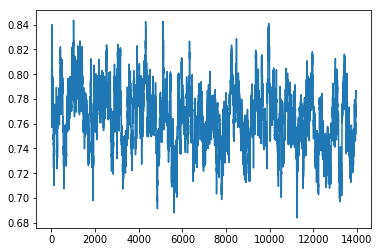

In [56]:
learn.sched.plot_loss()

In [57]:
learn.save('512_SeResNext50_ph1')

In [58]:
learn.load('512_SeResNext50_ph1')
pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_6_cyclic.csv')

In [59]:
learn.fit(lrs/10,1, wds=wd,cycle_len=16,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.728206   0.68791    0.967761   1.236777  
    1      0.781594   0.686255   0.967727   1.241132           
    2      0.723164   0.687543   0.968263   1.231486           
    3      0.734272   0.683614   0.967898   1.231713           
    4      0.732791   0.677931   0.968069   1.231907           
    5      0.7298     0.675114   0.968183   1.226317           
    6      0.718759   0.672941   0.968536   1.230101           
    7      0.719348   0.674216   0.968468   1.221914           
    8      0.750472   0.668775   0.968628   1.227721           
    9      0.71544    0.668925   0.968707   1.227156           
    10     0.71032    0.664461   0.968992   1.224632           
    11     0.747331   0.668046   0.968673   1.222994           
    12     0.687017   0.664117   0.968616   1.222007           
    13     0.708986   0.662011   0.969061   1.222065           
    14     0.749305   0.661583   0.968981   1.221

[0.6611414109169486, 0.9692315135552918, 1.2199920461523206]

In [60]:
learn.save('512_SeResNext50_ph2')

In [61]:
learn.fit(lrs/3,1, wds=wd,cycle_len=9,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.727234   0.677654   0.968491   1.220745  
    1      0.712676   0.673115   0.968138   1.225033           
    2      0.691448   0.672338   0.968434   1.209406           
    3      0.67181    0.682891   0.968924   1.196288           
    4      0.702909   0.655203   0.969471   1.20603            
    5      0.721483   0.638433   0.969972   1.209929           
    6      0.625668   0.641593   0.970086   1.199806           
    7      0.704184   0.633087   0.970063   1.208483           
    8      0.632348   0.638117   0.970337   1.198934           


[0.6381167059083158, 0.9703369013580001, 1.198934059806439]

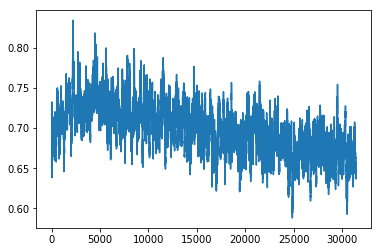

In [62]:
learn.sched.plot_loss()

In [64]:
pred = make_prediction()
save_pred(pred, th_t, fname=f'protein_class_6_cyclic.csv')

In [ ]:
pred = make_prediction()
save_pred(pred, 0.5, fname=f'protein_class_6_0.5_cyclic.csv')

In [65]:
learn.fit(lrs,1, wds=wd,cycle_len=6,use_clr=(20,8))

epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.772466   0.715455   0.967818   1.199894  
    1      0.729953   0.709808   0.966098   1.205288           
 55%|█████▌    | 1931/3492 [19:51<16:03,  1.62it/s, loss=0.675]

KeyboardInterrupt: 

In [63]:
learn.save('512_SeResNext50_ph3')

##### Next Schedule Notes

1. Increase the 256x256 number of epochs - can we get more out of this intermediary step?
1. Increase the training rate of the 512x512 phase - can this learn faster?

##### 9th Nov - find best fold

In [ ]:
lr = 3e-4
wd = 1e-7
lrs=np.array([lr/10,lr/3,lr])

sz = 256
bs = 16

In [ ]:
for k in range(folds):
    md = get_fold(sz,bs,k)
    learn = get_resnext50_model(md)
    learn.unfreeze()
    learn.fit(lr, 1, wds=wd, cycle_len=10, use_clr_beta=(10,10,0.85,0.9), use_wd_sched=True)
    learn.save(f'SEResNextFold_test_{k}')

### Train all folds

#### Cyclic

In [ ]:
def get_fold_model(sz, bs, k):
    md = get_fold(sz,bs,k)
    learn = get_resnext50_model(md)
    learn.freeze_to(1)
    return learn

In [ ]:
lr = 3e-4
wd = 1e-7
nw = 6
lrs=np.array([lr/10,lr/3,lr])

for k in range(folds):
    # 128x128 phase
    learn = get_fold_model(128, 24, k)
    
    learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

    learn.unfreeze()
    learn.bn_freeze(True)

    learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

    learn.save(f'128_SeResNext50_{k}')

    # 256 x 256 phase
    learn = get_fold_model(256, 16, k)
    learn.load(f'128_SeResNext50_{k}')

    learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

    learn.unfreeze()
    learn.bn_freeze(True)

    learn.fit(lrs/2,2,wds=wd, cycle_len=10,use_clr=(20,8))

    learn.save(f'256_SeResNext50_{k}')

    #512 x 512 phase
    learn = get_fold_model(512, 8, k)
    learn.load(f'256_SeResNext50_{k}')

    learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

    learn.unfreeze()
    learn.bn_freeze(True)

    learn.fit(lrs/3, 2, wds=wd,cycle_len=16,use_clr=(20,8))
    
    learn.fit(lrs/8, 1, wds=wd,cycle_len=9,use_clr=(20,8))

    learn.save(f'512_SeResNext50_ph1_{k}')

#### 1 Cycle

In [40]:
lr = 3e-4
lrs=np.array([lr/10,lr/3,lr])

In [42]:
for k in range(folds):
    md = get_fold(sz,bs,k)
    learn = get_resnext50_model(md)
    learn.load(f'SEResNext50_Mk1_final')
    learn.unfreeze()

    phase=1
    learn.fit(lrs/4,2,
              cycle_len=12,use_clr=(10,20), 
              best_save_name=f'SEResNext50_{k}_{phase}_mfolds')

    phase=2
    learn.fit(lrs/4,2,
              cycle_len=12,use_clr=(10,20), 
              best_save_name=f'SEResNext50_{k}_{phase}_mfolds')

    phase=3
    learn.fit(lrs/16,1,
              cycle_len=9,use_clr=(5,20),
              best_save_name=f'SEResNext50_{k}_{phase}_mfolds')
    
    phase=4
    learn.fit(lrs/16,1,
          cycle_len=12,use_clr=(5,20),
          best_save_name=f'SEResNext50_{k}_{phase}_mfolds')

    learn.save(f'SEResNext50_{k}_{phase}_mfolds_final')
    
    pred = make_prediction()
    save_pred(pred, th_t, fname=f'protein_class_{k}.csv')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.561516   0.322511   0.983827  
    1      0.50706    0.337665   0.982777                      
    2      0.533345   0.333185   0.983008                      
    3      0.509905   0.331454   0.983193                      
    4      0.45943    0.335594   0.982823                      
    5      0.480436   0.336579   0.982835                      
    6      0.449071   0.338555   0.982489                      
    7      0.449808   0.342649   0.982662                      
    8      0.466516   0.335259   0.982847                      
    9      0.424796   0.341782   0.9831                        
    10     0.430926   0.331194   0.983666                      
    11     0.451149   0.332387   0.983758                      
    12     0.391414   0.360802   0.981993                      
    13     0.411199   0.369752   0.982004                      
    14     0.417081   0.373691   0.981416                   

epoch      trn_loss   val_loss   acc                           
    0      0.364663   0.395059   0.981162  
    1      0.401705   0.406237   0.981197                      
    2      0.350917   0.406265   0.981993                      
    3      0.374285   0.418444   0.98092                       
    4      0.377207   0.423528   0.980886                      
    5      0.39707    0.427128   0.981105                      
    6      0.341997   0.415272   0.981255                      
    7      0.296755   0.408026   0.981624                      
    8      0.333297   0.417009   0.981866                      
    9      0.311002   0.436773   0.981024                      
    10     0.320172   0.428638   0.981393                      
    11     0.324638   0.41876    0.98182                       
    12     0.3252     0.449242   0.980909                      
    13     0.330315   0.462604   0.979767                      
    14     0.322214   0.462212   0.980632                   

epoch      trn_loss   val_loss   acc                           
    0      0.246534   0.49259    0.980932  
    1      0.235799   0.481788   0.98107                       
    2      0.252157   0.509939   0.981001                      
    3      0.235634   0.488389   0.981635                      
    4      0.228024   0.496234   0.981035                      
    5      0.257285   0.501558   0.980909                      
    6      0.262154   0.50743    0.980989                      
    7      0.249349   0.507028   0.980874                      
    8      0.253412   0.512421   0.980862                      


epoch      trn_loss   val_loss   acc                           
    0      0.230893   0.500597   0.980851  
    1      0.211422   0.484886   0.981232                      
    2      0.224332   0.533511   0.980516                      
    3      0.237798   0.512704   0.981243                      
    4      0.203887   0.520146   0.981139                      
    5      0.24133    0.521694   0.980424                      
    6      0.24196    0.511134   0.980862                      
    7      0.251287   0.496899   0.981405                      
    8      0.223016   0.533166   0.980724                      
    9      0.224011   0.52775    0.981382                      
    10     0.210874   0.53933    0.980493                      
    11     0.208699   0.519941   0.981047                      


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc                           
    0      0.534535   0.333124   0.982808  
    1      0.517354   0.346239   0.982495                      
    2      0.499761   0.346503   0.982115                      
    3      0.505693   0.350163   0.982193                      
    4      0.477361   0.345781   0.982327                      
    5      0.483133   0.344059   0.982886                      
 83%|████████▎ | 2877/3484 [27:21<05:46,  1.75it/s, loss=0.441]

KeyboardInterrupt: 

# Validation Score

In [ ]:
import scipy.optimize as opt

In [69]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learn.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [70]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [71]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [0.67447 0.77441 0.6432  0.71032 0.7633  0.58246 0.59099 0.61067 0.59715 0.83648 0.47122 0.71517 0.73005
 0.91396 0.72482 0.44042 0.88081 0.75626 0.519   0.60685 0.80563 0.61776 0.75221 0.76512 0.74962 0.60664
 0.71887 0.63454]
F1 macro:  0.7140915172064203
F1 macro (th = 0.5):  0.6832496715576231
F1 micro:  0.7769354338697405


In [72]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.43182 0.04031 0.11328 0.04902 0.05763 0.08668 0.0318  0.08782 0.00265 0.00104 0.00104 0.0318  0.02347
 0.01722 0.037   0.00123 0.0158  0.00823 0.03341 0.04325 0.00729 0.12416 0.02697 0.0987  0.00833 0.30803
 0.01306 0.00028]
Fractions (true):  [0.41355 0.04154 0.11772 0.05139 0.06057 0.08167 0.03322 0.09217 0.00199 0.00151 0.00095 0.03615 0.02423
 0.01845 0.03511 0.00076 0.01902 0.00757 0.03    0.04902 0.00577 0.12321 0.02725 0.09577 0.01107 0.26517
 0.01107 0.00066]


# Submission

In [73]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.46804 0.04478 0.09306 0.03786 0.05264 0.0746  0.02991 0.07375 0.00154 0.00111 0.00051 0.03717 0.03179
 0.0282  0.05042 0.00009 0.03837 0.02239 0.02589 0.03965 0.00667 0.15023 0.03076 0.11152 0.00872 0.35208
 0.02042 0.00077]


In [74]:
preds_t,y_t = learn.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1)

In [75]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [76]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [77]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.80374 0.49925 0.76483 0.21822 0.24233 0.49543 0.26365 0.54937 0.10824 0.1054  0.1     0.42081 0.25919
 0.89889 0.77842 0.1     0.69168 0.86501 0.56459 0.292   0.35843 0.70467 0.5345  0.81766 0.45866 0.80764
 0.27445 0.1    ]
Fractions:  [0.36361 0.04384 0.07546 0.05871 0.07426 0.0752  0.0435  0.07503 0.00461 0.00419 0.00171 0.04392 0.04341
 0.01461 0.04384 0.00205 0.0288  0.01461 0.02888 0.05922 0.01008 0.1269  0.02888 0.0758  0.01    0.22466
 0.0288  0.00137]
Fractions (th = 0.5):  [0.52777 0.04384 0.11571 0.0382  0.04974 0.07469 0.02512 0.08067 0.00162 0.00103 0.00068 0.03991 0.02863
 0.0282  0.05461 0.00009 0.03863 0.02495 0.03179 0.04187 0.00795 0.17886 0.02991 0.1275  0.00974 0.41386
 0.01846 0.00009]


In [78]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [79]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [80]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [81]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [82]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.7347  0.56408 0.50024 0.30176 0.36257 0.45713 0.37413 0.41914 0.50788 0.35831 0.2295  0.57945 0.64883
 0.80423 0.91007 0.24861 0.91427 0.97507 0.55993 0.41841 0.70555 0.72181 0.60697 0.7074  0.41463 0.76006
 0.84881 0.27531]
Fractions:  [0.41736 0.04008 0.11562 0.04982 0.05931 0.08041 0.0317  0.09075 0.00162 0.00137 0.00085 0.03512 0.02196
 0.01718 0.03563 0.0006  0.01718 0.00829 0.02897 0.0482  0.00547 0.12177 0.02615 0.0958  0.01025 0.26782
 0.01051 0.00034]


# Multiple Folds Submission

In [38]:
pred_array = np.zeros((11702, 28),dtype=float)

for k in range(folds):
    learn.load(f'SEResNext50_{k}_final')
    preds_t,y_t = learn.TTA(n_aug=8, is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.max(axis=-1)
    pred_array = pred_t + pred_array

pred_array = pred_array / folds

FileNotFoundError: [Errno 2] No such file or directory: './models/SEResNext50_0_final.h5'

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
(pred_array > th_t).mean(axis=0)

In [ ]:
save_pred(pred_array,th_t,'protein_classification_mfolds.csv')

In [40]:
# pred_list = []
# for line in pred_array:
#     s = ' '.join(list([str(i) for i in np.nonzero(line>th_t)[0]]))
#     pred_list.append(s)

In [41]:
# sample_df = pd.read_csv(SAMPLE)
# sample_list = list(sample_df.Id)
# pred_dic = dict((key, value) for (key, value) 
#                 in zip(learn.data.test_ds.fnames,pred_list))
# pred_list_cor = [pred_dic[id] for id in sample_list]
# df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
# df.to_csv('protein_classification.csv', header=True, index=False)

# Notes

ResNet50 (pretrained)
1. lr=1e-2
1. learn.fit(lrs/4,4,cycle_len=2,use_clr=(10,20), best_save_name=f'{arch}_{phase}')
1. learn.fit(lrs/4,2,cycle_len=23,use_clr=(10,20), best_save_name=f'{arch}_{phase}')
1. learn.fit(lrs/8,1,cycle_len=10,use_clr=(5,20), best_save_name=f'{arch}_{phase}')

LB Score: 0.50 (modelname:<function resnet50 at 0x7f41f50d3400> _3), 

Resnet50 - 0.7056019664330974 0.6823389611938516, LB:0.503

SEResNext50
1. lr=1e-4

#### Other ideas
1. Set gradient clipping to 1.0 instead of 0.25
1. Try another Focal Loss implementation
1. Increase batch size - bs=8 so far means 7GB

In [ ]:
class FocalLoss(nn.Module):
    def _init_(self, num_classes=28):
        super()._init_()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = targ
        x = pred
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, 
                          size_average=False)/self.num_classes
    
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)